In [87]:
import json
import time
import pytz
import traceback
import time_uuid
from pytz import timezone
from datetime import datetime
from pyspark.sql import types
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import SQLContext, Row
from pyspark import SparkContext, SparkConf
from config import *

In [88]:
import warnings
import matplotlib
warnings.filterwarnings('ignore')

%matplotlib inline
import pandas as pd

In [89]:
sc.stop()

### Connecting to Cassandra and loading data into Pyspark's Dataframes

In [90]:
conf = SparkConf()\
    .setAppName(APPNAME)\
    .setMaster(MASTER)\
    .set("spark.cassandra.connection.host", CASSANDRA_HOST)\
    .set("spark.cassandra.connection.port", CASSANDRA_PORT)\
    .set("spark.cassandra.auth.username", CASSANDRA_USERNAME)\
    .set("spark.cassandra.auth.password", CASSANDRA_PASSWORD)

In [91]:
sc = SparkContext(MASTER, APPNAME, conf=conf)
sqlContext = SQLContext(sc)
sqlContext.sql("""CREATE TEMPORARY TABLE %s \
                  USING org.apache.spark.sql.cassandra \
                  OPTIONS ( table "%s", \
                            keyspace "%s", \
                            cluster "Test Cluster", \
                            pushdown "true") \
              """ % (TABLE_QUERYABLE, TABLE_QUERYABLE, KEYSPACE))

DataFrame[]

In [92]:
query = "SELECT * FROM %s" % (TABLE_QUERYABLE)
df_payload = sqlContext.sql(query)
df_payload.cache()
df_payload.printSchema()

root
 |-- bucket_id: string (nullable = true)
 |-- unix_timestamp: long (nullable = true)
 |-- age: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- email: string (nullable = true)
 |-- event_id: string (nullable = true)
 |-- event_name: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- job: string (nullable = true)
 |-- name: string (nullable = true)
 |-- zipcode: string (nullable = true)



### Schema of Data

In [93]:
pd.DataFrame(df_payload.take(3), columns=df_payload.columns).transpose()

,0,1,2
bucket_id,2000-11-27,2000-11-27,2000-11-27
unix_timestamp,148917251752308992,148917249744547104,148917242569626400
age,43,58,40
city,Port Shellyshire,Starkfurt,North Alexandermouth
created_at,2014-08-12 08:52:52,2016-02-13 07:04:53,2016-07-24 04:43:03
email,bryantjill@yahoo.com,amandawilson@williams.com,igreene@yahoo.com
event_id,08aad1b4-05c4-11e7-bb33-acbc32780117,fcb337b6-05c3-11e7-ae50-acbc32780117,d1ef2850-05c3-11e7-bcef-acbc32780117
event_name,EventName6619,EventName6649,EventName6921
gender,M,F,F
job,"Engineer, civil (consulting)",Corporate investment banker,Environmental manager


### Doing some basic analysis for demonstration purpose

In [94]:
numeric_features = [t[0] for t in df_payload.dtypes if t[1] == 'int' or t[1] == 'double']

In [95]:
sampled_data = df_payload.select(numeric_features).sample(False, 0.10).toPandas()

### Distribution of Age across all the data inside Cassandra

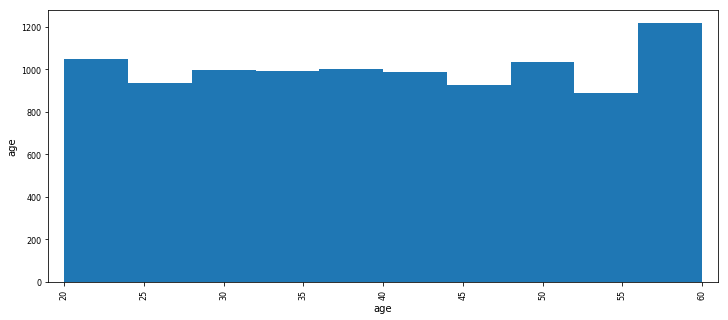

In [96]:
axs = pd.scatter_matrix(sampled_data, figsize=(12, 5));

## Creating a Random Forest Machine Learning Model on the Cassandra Data

In [100]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier as RF
from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler, SQLTransformer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np
import random
import functools
from pyspark.ml.feature import OneHotEncoder

#### Loading data from Cassandra 

In [101]:
tableData = sqlContext.sql("SELECT * FROM %s" % (TABLE_QUERYABLE))
tableData.dtypes

[('bucket_id', 'string'),
 ('unix_timestamp', 'bigint'),
 ('age', 'int'),
 ('city', 'string'),
 ('created_at', 'timestamp'),
 ('email', 'string'),
 ('event_id', 'string'),
 ('event_name', 'string'),
 ('gender', 'string'),
 ('job', 'string'),
 ('name', 'string'),
 ('zipcode', 'string')]

In [102]:
cols_select = ['age', 'city', 'email', 'gender', 'job', 'zipcode']
df = tableData.select(cols_select).dropDuplicates()
df.show(5, False)

+---+--------------+--------------------------+------+------------------------+-------+
|age|city          |email                     |gender|job                     |zipcode|
+---+--------------+--------------------------+------+------------------------+-------+
|60 |Zacharyborough|msingleton@green-myers.com|M     |Veterinary surgeon      |25009  |
|60 |Torreschester |robert38@gmail.com        |M     |Dancer                  |85770  |
|20 |Kevinport     |janet94@bennett.net       |F     |Risk analyst            |32970  |
|51 |Zacharyview   |powelljames@osborne.info  |M     |Journalist, broadcasting|67384  |
|32 |Lunaside      |cookerika@sandoval.com    |F     |Geologist, engineering  |58001  |
+---+--------------+--------------------------+------+------------------------+-------+
only showing top 5 rows



#### Adding user behavior (POSITIVE, NOT-POSITIVE) randomly as our data is randomly generated

In [103]:
def func(d):
    p = {}
    for x in d:
        p['age'] = d.age
        p['city'] = d.city
        p['email'] = d.email
        p['gender'] = d.gender
        p['job'] = d.job
        p['zipcode'] = d.zipcode
    p['behaviour'] = str(random.choice(['POSITIVE', 'NEGATIVE']))
    return p

features = df.map(lambda x: func(x))

In [104]:
features.toDF().show()

+---+---------+-----------------+--------------------+------+--------------------+-------+
|age|behaviour|             city|               email|gender|                 job|zipcode|
+---+---------+-----------------+--------------------+------+--------------------+-------+
| 60| POSITIVE|   Zacharyborough|msingleton@green-...|     M|  Veterinary surgeon|  25009|
| 60| POSITIVE|    Torreschester|  robert38@gmail.com|     M|              Dancer|  85770|
| 20| POSITIVE|        Kevinport| janet94@bennett.net|     F|        Risk analyst|  32970|
| 51| NEGATIVE|      Zacharyview|powelljames@osbor...|     M|Journalist, broad...|  67384|
| 32| POSITIVE|         Lunaside|cookerika@sandova...|     F|Geologist, engine...|  58001|
| 29| NEGATIVE|         Riceberg| diazterri@yahoo.com|     F|Architectural tec...|  53955|
| 56| NEGATIVE|     North Sandra|vjimenez@hotmail.com|     F|Historic building...|  11325|
| 53| POSITIVE|          New Amy|jeffreyarmstrong@...|     F|     Publishing copy|  20437|

#### Performing label encoding on the columns

In [105]:
from pyspark.sql.functions import UserDefinedFunction
def labelForAge(s):
    s = int(s)
    if s <= 20:
        return 0.0
    elif s > 20 and s <= 40:
        return 1.0
    elif s > 40 and s <= 50:
        return 2.0
    elif s > 50 and s <= 60:
        return 3.0
    else:
        return -1.0

def labelForCity(s):
    if len(s) <= 8:
        return 0.0
    elif s > 8 and s <= 10:
        return 1.0
    elif s > 10 and s <= 14:
        return 2.0
    elif s > 14 and s <= 20:
        return 3.0
    else:
        return -1.0

def labelForEmail(s):
    if len(s) <= 5:
        return 0.0
    elif s > 5 and s <= 7:
        return 1.0
    elif s > 7 and s <= 9:
        return 2.0
    elif s > 9 and s <= 12:
        return 3.0
    else:
        return -1.0

def labelForGender(s):
    if s == 'M':
        return 0.0
    elif s == 'F':
        return 1.0
    else:
        return -1.0
    
def labelForJob(s):
    s = s.lower()
    if 'engineer' in s:
        return 0.0
    elif 'architect' in s:
        return 1.0
    elif 'analyst' in s:
        return 2.0
    elif 'designer' in s:
        return 3.0
    elif 'officer' in s:
        return 4.0
    elif 'teacher' in s:
        return 5.0
    elif 'it' in s:
        return 6.0
    else:
        return -1.0   

def labelForZipcode(s):
    s = int(s)
    if s <= 10000:
        return 0.0
    elif s > 10000 and s <= 30000:
        return 1.0
    elif s > 30000 and s <= 50000:
        return 2.0
    elif s > 50000 and s <= 70000:
        return 3.0
    elif s > 70000 and s <= 90000:
        return 4.0
    elif s > 90000:
        return 5.0
    else:
        return -1.0

label_Age = UserDefinedFunction(labelForAge, DoubleType())
label_City = UserDefinedFunction(labelForCity, DoubleType())
label_Email = UserDefinedFunction(labelForEmail, DoubleType())
label_Gender = UserDefinedFunction(labelForGender, DoubleType())
label_Job = UserDefinedFunction(labelForJob, DoubleType())
label_Zipcode = UserDefinedFunction(labelForZipcode, DoubleType())

features_df = features.toDF()
labeledData = features_df.select(label_Age(features_df.age).alias('age_label'),\
                              label_City(features_df.city).alias('city_label'),\
                              label_Email(features_df.email).alias('email_label'),\
                              label_Gender(features_df.gender).alias('gender_label'),\
                              label_Job(features_df.job).alias('job_label'),\
                              label_Zipcode(features_df.zipcode).alias('zipcode_label'),\
                              features_df.behaviour)

In [106]:
labeledData.dtypes

[('age_label', 'double'),
 ('city_label', 'double'),
 ('email_label', 'double'),
 ('gender_label', 'double'),
 ('job_label', 'double'),
 ('zipcode_label', 'double'),
 ('behaviour', 'string')]

#### This is final labeled data, we are ready to train the model now

In [107]:
labeledData.show(5, False)

+---------+----------+-----------+------------+---------+-------------+---------+
|age_label|city_label|email_label|gender_label|job_label|zipcode_label|behaviour|
+---------+----------+-----------+------------+---------+-------------+---------+
|3.0      |-1.0      |-1.0       |0.0         |-1.0     |1.0          |POSITIVE |
|3.0      |-1.0      |-1.0       |0.0         |-1.0     |4.0          |POSITIVE |
|0.0      |-1.0      |-1.0       |1.0         |2.0      |2.0          |POSITIVE |
|3.0      |-1.0      |-1.0       |0.0         |-1.0     |3.0          |NEGATIVE |
|1.0      |0.0       |-1.0       |1.0         |0.0      |3.0          |POSITIVE |
+---------+----------+-----------+------------+---------+-------------+---------+
only showing top 5 rows



In [108]:
cols_new = ['age_label', 'city_label', 'email_label', 'gender_label', 'job_label', 'zipcode_label']
assembler_features = VectorAssembler(inputCols=cols_new, outputCol='features')
labelIndexer = StringIndexer(inputCol='behaviour', outputCol="label")
tmp = [assembler_features, labelIndexer]
pipeline = Pipeline(stages=tmp)

#### Splitting our data into training and test data. 80%-20%

In [109]:
allData = pipeline.fit(labeledData).transform(labeledData)
allData.cache()
trainingData, testData = allData.randomSplit([0.8,0.2], seed=0) # need to ensure same split for each time
print("Distribution of Pos and Neg in trainingData is: ", trainingData.groupBy("label").count().take(3))

('Distribution of Pos and Neg in trainingData is: ', [Row(label=1.0, count=39616), Row(label=0.0, count=40562)])


#### Training the model now

In [111]:
rf = RF(labelCol='label', featuresCol='features',numTrees=200)
fit = rf.fit(trainingData)
transformed = fit.transform(testData)

#### Model training is done. following table shows features, label, prediction, probability and rawPrediction of model

In [112]:
transformed.show(5, False)

+---------+----------+-----------+------------+---------+-------------+---------+----------------------------+-----+--------------------------------------+----------------------------------------+----------+
|age_label|city_label|email_label|gender_label|job_label|zipcode_label|behaviour|features                    |label|rawPrediction                         |probability                             |prediction|
+---------+----------+-----------+------------+---------+-------------+---------+----------------------------+-----+--------------------------------------+----------------------------------------+----------+
|3.0      |-1.0      |-1.0       |0.0         |-1.0     |1.0          |POSITIVE |[3.0,-1.0,-1.0,0.0,-1.0,1.0]|0.0  |[101.61328658886309,98.38671341113692]|[0.5080664329443154,0.49193356705568464]|0.0       |
|3.0      |-1.0      |-1.0       |0.0         |-1.0     |3.0          |POSITIVE |[3.0,-1.0,-1.0,0.0,-1.0,3.0]|0.0  |[101.80838855976837,98.19161144023165]|[0.5090419427

#### Calculating the ROC score now

In [113]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
results = transformed.select(['probability', 'label'])
 
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)
 
metrics = metric(scoreAndLabels)
print("The ROC score is (@numTrees=200): ", metrics.areaUnderROC)

('The ROC score is (@numTrees=200): ', 0.5013822034903597)


### Now, plotting the distributions of our predictions

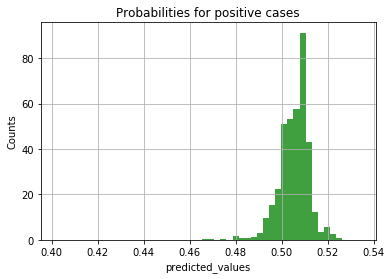

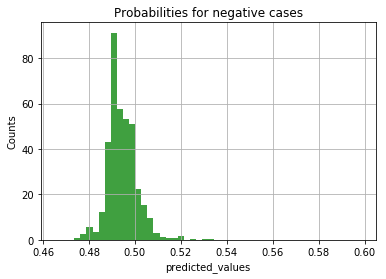

In [114]:
all_probs = transformed.select("probability").collect()
pos_probs = [i[0][0] for i in all_probs]
neg_probs = [i[0][1] for i in all_probs]
 
from matplotlib import pyplot as plt
%matplotlib inline
 
# pos
plt.hist(pos_probs, 50, normed=1, facecolor='green', alpha=0.75)
plt.xlabel('predicted_values')
plt.ylabel('Counts')
plt.title('Probabilities for positive cases')
plt.grid(True)
plt.show()
 
# neg
plt.hist(neg_probs, 50, normed=1, facecolor='green', alpha=0.75)
plt.xlabel('predicted_values')
plt.ylabel('Counts')
plt.title('Probabilities for negative cases')
plt.grid(True)
plt.show()